In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from igl import igl
from local_global import local_global

On this notebook we will comapare the local-global algorithm with the inplane proyection propoused for Sifert et al, for the desing of baromophes structures.

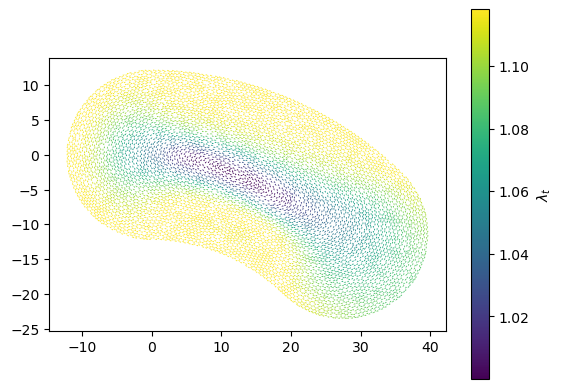

In [17]:
# Load the mesh and compute and create a in plane proyection u.
file_name = 'data/non_regular.obj'
v,f = igl.read_triangle_mesh(file_name)
# for this particular case we take the proyection over the xy plane
u = v[:,:2].copy()
# for use the in plane proyection aproach we need to compute the gradient of the height.
grad = igl.grad(v,f) # discrete gradient operator
d_h = grad.dot(v[:,2]) # gradient of the hieght
d_h = np.reshape(d_h,(len(f),3), order = 'F') 
hx = d_h[:,0]
hy = d_h[:,1]
lmt = np.sqrt(1+hx**2+hy**2) # strech of the channels
ux = -hy/np.sqrt(hx**2+hy**2) # director field
uy = hx/np.sqrt(hx**2+hy**2)
p = u[f].mean(axis= 1)  # centers of the triangles

fig, axs = plt.subplots(1,1)
cs = axs.quiver(p[:,0],p[:,1],ux,uy,lmt)
cbar = fig.colorbar(cs,label = '$\lambda_t$')
axs.set_aspect('equal', 'box')

From this director field and scalar field $\lambda_t$ we will make a stripe pattern of periode $d$, for this we will use the phasors algorithm to create syntetic patterns. 

Order to modify the local global algorithm for the baromoph desing we will clip the target inverse streching to $\sigma_{max} =1$ and $\left[ \sigma_{min} \right]^1_{\Sigma_{min}}$. 